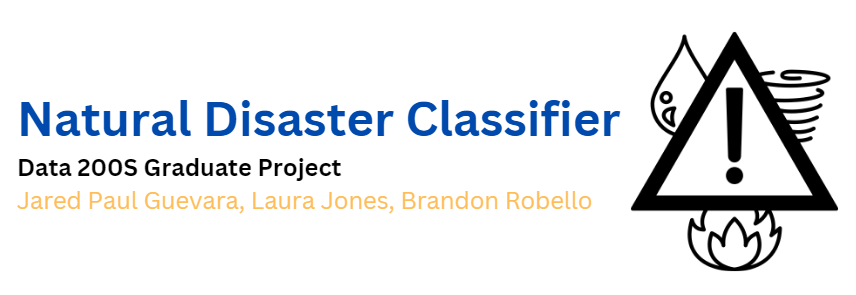


# Generating final test predictions


Generating the test predictions for both tasks consists of:

1. Loading libraries and utility functions

2. Generating predictions for Task A:  
   a. Loading test data

   b. Generating test data features

   c. Importing best model

   d. Fitting features and generating predictions

3. Generating predictions for Task B:  
   a. Loading test data

   b. Generating test data features

   c. Importing best model

   d. Fitting features and generating predictions


## 1. Loading libraries and utility functions


In [5]:
import json
from zipfile import ZipFile
import warnings
warnings.filterwarnings("ignore")

from data_utils import load_images
from feature_utils import get_sobel_features, get_gabor_features, get_local_binary_pattern

import pandas as pd
import numpy as np
from skimage.filters import gabor_kernel
import pickle

In [ ]:
def generate_gabor_kernels(theta_vals, sigma_vals, frequency_vals):
    """
    Generate a collection of Gabor filter kernels with specified parameters.

    Args:
        theta_vals (list or array): Range of orientations for the Gabor filter kernels.
        sigma_vals (list or array): Range of sigma values (bandwidths) for the kernels.
        frequency_vals (list or array): Range of frequencies for the kernels.

    Returns:
        list: A list of Gabor kernels with specified parameters.
    """
    kernels = []
    for theta in theta_vals:
        for sigma in sigma_vals:
            for frequency in frequency_vals:
                kernel = np.real(gabor_kernel(frequency, theta=theta, sigma_x=sigma, sigma_y=sigma))
                kernels.append(kernel)
    return kernels

def extract_combined_features(image, gabor_kernels):
    """
    Extract combined features (Sobel, Gabor, LBP) from an image and summarize with statistical measures.
    This version supports multiple Gabor kernels.

    Args:
        image (ndarray): An image array in RGB format.
        gabor_kernels (list): A list of Gabor kernels for feature extraction.

    Returns:
        ndarray: A 1D array (feature vector) summarizing the extracted features.
    """
    # Initialize dictionary to collect features
    features_dict = {}

    # Sobel features
    sobel_features = get_sobel_features(image).flatten()
    features_dict['sobel_mean'] = sobel_features.mean()
    features_dict['sobel_var'] = sobel_features.var()

    # Gabor features
    for i, kernel in enumerate(gabor_kernels):
        gabor_features = get_gabor_features(image, kernel).flatten()
        features_dict[f'gabor_{i}_mean'] = gabor_features.mean()
        features_dict[f'gabor_{i}_var'] = gabor_features.var()

    # LBP features
    lbp_features = get_local_binary_pattern(image).flatten()
    features_dict['lbp_mean'] = lbp_features.mean()
    features_dict['lbp_var'] = lbp_features.var()

    return features_dict

def color_coverage(image, area, thresholds):
  """
  This function finds the percent coverage of pixels that reach a defined threshold
  of intensity for a given color channel.

  Args:
        image (ndarray): Numpy array representation of an image.
        area (int): Total pixel area of an image.
        rgb (int): Integer representing the color channel (0 for red, 1 for green, 2 for blue).
        threshold (float): The threshold intensity of pixels.

    Returns:
        percent_color (float): The percentage of pixels in an image that cross the threshold intensity.
  """
  colors_dict = {0:'red', 1:'green', 2:'blue'}
  percent_colors = []
  for rgb, threshold in enumerate(thresholds):
    pixel_count = (image['image_matrix'][:,:,rgb] >= threshold).sum()
    percent_color = pixel_count / area
    percent_colors.append((colors_dict[rgb], percent_color))
  return percent_colors

def color_coverage_column(row, thresholds):
    """
    This function builds upon the existing `color_coverage` function by allowing for the row-wise application
    for each image.

    Args:
        row (ndarray): Numpy array representation of an image.
        thresholds (list): List of thresholds corresponding to each color channel (0 = red, 1 = green, 2 = blue).

    Returns:
        row (ndarray): New row with color coverage features appended.
    """
    coverage = color_coverage(row, row['total_pixels'], thresholds)
    for i, (color, percent_coverage) in enumerate(coverage):
        col_name = f'area of {color} pixels above {thresholds[i]}'
        row[col_name] = percent_coverage
    return row

## 2. Generating predictions for Task A


### 2a. Loading test data


In [6]:
config_path = './config.json'
# Loading configuration settings from config.json file
with open(config_path) as config_file:
    config = json.load(config_file)
    data_zip = config['data_zip']
    data_dir = config['data_dir']

# Unzipping the file containing all of the data
with ZipFile(data_zip) as zip_file:
    zip_file.extractall('../data/')

test_data_A = pd.DataFrame(pd.Series(load_images(data_dir + '/test_images_flooding-fire.npz'))).rename({0:'image_matrix'}, axis=1)
test_data_A['total_pixels'] = test_data_A['image_matrix'].apply(lambda x: x.shape[0] * x.shape[1]) 
print('First five rows from the Task A test data: ')
display(test_data_A.head())
print(f'Number of images: {len(test_data_A)}')

First five rows from the Task A test data: 


,image_matrix,total_pixels
0,"[[[129, 144, 135], [132, 145, 133], [128, 139,...",570
1,"[[[46, 80, 64], [50, 87, 69], [55, 91, 74], [5...",7392
2,"[[[61, 78, 73], [62, 81, 75], [59, 79, 72], [5...",4575
3,"[[[79, 87, 89], [76, 84, 85], [58, 65, 66], [9...",1551
4,"[[[62, 82, 69], [69, 90, 77], [79, 102, 88], [...",8686


Number of images: 3847


### 2b. Generating test data features


In [8]:
theta_vals = [0, np.pi/4, np.pi/2]
sigma_vals = [1, 2]
frequency_vals = [0.6, 0.8]

# Generate Gabor kernels
gabor_kernels = generate_gabor_kernels(theta_vals, sigma_vals, frequency_vals)

feature_df = pd.DataFrame()

# Process each dataset and extract features
features_list = []
for image in test_data_A['image_matrix']:
    features = extract_combined_features(image, gabor_kernels)
    features_list.append(features)

features_df_A = pd.DataFrame(features_list)
print('First five rows of features dataframe for Task A:')
features_df_A.head()

First five rows of features dataframe for Task A:


,sobel_mean,sobel_var,gabor_0_mean,gabor_0_var,gabor_1_mean,gabor_1_var,gabor_2_mean,gabor_2_var,gabor_3_mean,gabor_3_var,...,gabor_8_mean,gabor_8_var,gabor_9_mean,gabor_9_var,gabor_10_mean,gabor_10_var,gabor_11_mean,gabor_11_var,lbp_mean,lbp_var
0,0.055915,0.006032,0.023111,0.000304,0.241004,0.002681,-0.000157,0.000042,0.022974,0.000421,...,0.023111,0.000243,0.241004,0.002075,-0.000157,0.000064,0.022974,0.000134,4.710526,6.437258
1,0.038324,0.003315,0.018876,0.000267,0.196840,0.005455,-0.000128,0.000048,0.018764,0.000306,...,0.018876,0.000190,0.196840,0.005175,-0.000128,0.000032,0.018764,0.000154,5.084010,8.494430
2,0.022182,0.000317,0.012969,0.000019,0.135240,0.000689,-0.000088,0.000002,0.012892,0.000022,...,0.012969,0.000034,0.135240,0.000716,-0.000088,0.000005,0.012892,0.000034,4.901639,7.540926
3,0.057455,0.003224,0.025565,0.000430,0.266596,0.006481,-0.000174,0.000074,0.025414,0.000408,...,0.025565,0.000280,0.266596,0.005978,-0.000174,0.000049,0.025414,0.000229,4.855577,8.591650
4,0.046116,0.002198,0.018521,0.000094,0.193132,0.002802,-0.000126,0.000008,0.018411,0.000157,...,0.018521,0.000077,0.193132,0.002703,-0.000126,0.000008,0.018411,0.000120,4.642183,5.244060


In [9]:
# Use subset of features that Task A model was trained on only
features_df_A = features_df_A[['lbp_var', 'lbp_mean', 'sobel_mean', 'gabor_7_var', 'gabor_3_var']]
test_data_A = pd.concat([test_data_A, features_df_A], axis = 1)

print('First five rows from the Task A test data after appending image filter features: ')
display(test_data_A.head())
assert(len(test_data_A) == 3847)

First five rows from the Task A test data after appending image filter features: 


,image_matrix,total_pixels,lbp_var,lbp_mean,sobel_mean,gabor_7_var,gabor_3_var
0,"[[[129, 144, 135], [132, 145, 133], [128, 139,...",570,6.437258,4.710526,0.055915,7.157603e-07,0.000421
1,"[[[46, 80, 64], [50, 87, 69], [55, 91, 74], [5...",7392,8.494430,5.084010,0.038324,2.686521e-06,0.000306
2,"[[[61, 78, 73], [62, 81, 75], [59, 79, 72], [5...",4575,7.540926,4.901639,0.022182,5.192943e-07,0.000022
3,"[[[79, 87, 89], [76, 84, 85], [58, 65, 66], [9...",1551,8.591650,4.855577,0.057455,1.464463e-05,0.000408
4,"[[[62, 82, 69], [69, 90, 77], [79, 102, 88], [...",8686,5.244060,4.642183,0.046116,3.765139e-07,0.000157


In [10]:
# Generate color coverage features
test_data_A = test_data_A.apply(lambda x: color_coverage_column(x, [80, 104, 97]),axis=1)

print('First five rows from the Task A test data after appending color features: ')
display(test_data_A.head())
assert(len(test_data_A) == 3847)

First five rows from the Task A test data after appending color features: 


,image_matrix,total_pixels,lbp_var,lbp_mean,sobel_mean,gabor_7_var,gabor_3_var,area of red pixels above 80,area of green pixels above 104,area of blue pixels above 97
0,"[[[129, 144, 135], [132, 145, 133], [128, 139,...",570,6.437258,4.710526,0.055915,7.157603e-07,0.000421,0.852632,0.885965,0.898246
1,"[[[46, 80, 64], [50, 87, 69], [55, 91, 74], [5...",7392,8.494430,5.084010,0.038324,2.686521e-06,0.000306,0.367695,0.442776,0.401245
2,"[[[61, 78, 73], [62, 81, 75], [59, 79, 72], [5...",4575,7.540926,4.901639,0.022182,5.192943e-07,0.000022,0.131148,0.120656,0.134863
3,"[[[79, 87, 89], [76, 84, 85], [58, 65, 66], [9...",1551,8.591650,4.855577,0.057455,1.464463e-05,0.000408,0.822050,0.810445,0.818182
4,"[[[62, 82, 69], [69, 90, 77], [79, 102, 88], [...",8686,5.244060,4.642183,0.046116,3.765139e-07,0.000157,0.621230,0.635621,0.643910


### 2c. Importing best model


In [11]:
# Use pickle library to import model
with open('../models/task_A_model.pkl', 'rb') as f:
    task_A_model = pickle.load(f)

In [12]:
# Create subset of X that only contains features
test_X = test_data_A.iloc[:, 2:]
test_X.head()

,lbp_var,lbp_mean,sobel_mean,gabor_7_var,gabor_3_var,area of red pixels above 80,area of green pixels above 104,area of blue pixels above 97
0,6.437258,4.710526,0.055915,7.157603e-07,0.000421,0.852632,0.885965,0.898246
1,8.494430,5.084010,0.038324,2.686521e-06,0.000306,0.367695,0.442776,0.401245
2,7.540926,4.901639,0.022182,5.192943e-07,0.000022,0.131148,0.120656,0.134863
3,8.591650,4.855577,0.057455,1.464463e-05,0.000408,0.822050,0.810445,0.818182
4,5.244060,4.642183,0.046116,3.765139e-07,0.000157,0.621230,0.635621,0.643910


### 2d. Fitting features and generating predictions


In [13]:
# Generate predictions by fitting test X to model
test_preds = pd.DataFrame(task_A_model.predict(test_X)).rename({0:'pred'}, axis=1)
test_preds

,pred
0,0
1,0
2,0
3,0
4,1
...,...
3842,0
3843,0
3844,0
3845,1


In [14]:
test_preds.to_csv('../predictions/test_images_flooding-fire_predictions.csv', index=False)

## 3. Generating predictions for Task B


### 3a. Loading test data


In [15]:
test_data_B = pd.DataFrame(pd.Series(load_images(data_dir + '/test_images_hurricane-matthew.npz'))).rename({0:'image_matrix'}, axis=1)
test_data_B['total_pixels'] = test_data_B['image_matrix'].apply(lambda x: x.shape[0] * x.shape[1]) 
print('First five rows from the Task B test data: ')
display(test_data_B.head())
print(f'Number of images: {len(test_data_B)}')

First five rows from the Task B test data: 


,image_matrix,total_pixels
0,"[[[118, 140, 143], [113, 135, 138], [110, 132,...",24649
1,"[[[71, 93, 75], [92, 114, 96], [93, 115, 96], ...",6080
2,"[[[96, 116, 106], [95, 115, 106], [84, 103, 93...",1924
3,"[[[51, 87, 58], [57, 97, 65], [61, 103, 69], [...",2610
4,"[[[113, 133, 136], [125, 145, 149], [109, 131,...",3844


Number of images: 2788


### 3b. Generating test data features


In [16]:
features_list = []
for image in test_data_B['image_matrix']:
    features = extract_combined_features(image, gabor_kernels)
    features_list.append(features)

features_df_B = pd.DataFrame(features_list)
print('First five rows of features dataframe for Task B:')
features_df_B.head()

First five rows of features dataframe for Task B:


,sobel_mean,sobel_var,gabor_0_mean,gabor_0_var,gabor_1_mean,gabor_1_var,gabor_2_mean,gabor_2_var,gabor_3_mean,gabor_3_var,...,gabor_8_mean,gabor_8_var,gabor_9_mean,gabor_9_var,gabor_10_mean,gabor_10_var,gabor_11_mean,gabor_11_var,lbp_mean,lbp_var
0,0.047741,0.001800,0.017850,0.000132,0.186142,0.003651,-0.000121,0.000020,0.017744,0.000167,...,0.017850,0.000059,0.186142,0.003518,-0.000121,0.000002,0.017744,0.000089,4.574303,5.234945
1,0.041854,0.001391,0.012991,0.000074,0.135473,0.001721,-0.000088,0.000008,0.012914,0.000123,...,0.012991,0.000063,0.135473,0.001668,-0.000088,0.000009,0.012914,0.000086,4.503125,5.004267
2,0.049768,0.001432,0.015968,0.000068,0.166517,0.001963,-0.000109,0.000006,0.015873,0.000095,...,0.015968,0.000091,0.166517,0.002076,-0.000109,0.000014,0.015873,0.000134,4.431393,5.058183
3,0.067173,0.003101,0.020448,0.000174,0.213236,0.004063,-0.000139,0.000018,0.020327,0.000256,...,0.020448,0.000288,0.213236,0.004000,-0.000139,0.000047,0.020327,0.000230,4.686973,8.070980
4,0.034751,0.001245,0.016257,0.000050,0.169527,0.001057,-0.000111,0.000004,0.016160,0.000076,...,0.016257,0.000073,0.169527,0.001067,-0.000111,0.000013,0.016160,0.000083,4.686264,6.838615


In [17]:
# Use subset of features that Task B model was trained on only
features_df_B = features_df_B[['lbp_var', 'gabor_7_var', 'gabor_6_var', 'lbp_mean', 'sobel_mean', 'gabor_5_var', 'gabor_4_var', 'sobel_var', 'gabor_9_var', 'gabor_11_var', 'gabor_3_var', 'gabor_1_var', 'gabor_10_var', 'gabor_2_var', 'gabor_8_var', 'gabor_0_var']]
test_data_B = pd.concat([test_data_B, features_df_B], axis = 1)

print('First five rows from the Task B test data after appending image filter features: ')
display(test_data_B.head())
assert(len(test_data_B) == 2788)

First five rows from the Task B test data after appending image filter features: 


,image_matrix,total_pixels,lbp_var,gabor_7_var,gabor_6_var,lbp_mean,sobel_mean,gabor_5_var,gabor_4_var,sobel_var,gabor_9_var,gabor_11_var,gabor_3_var,gabor_1_var,gabor_10_var,gabor_2_var,gabor_8_var,gabor_0_var
0,"[[[118, 140, 143], [113, 135, 138], [110, 132,...",24649,5.234945,2.551454e-07,2.783091e-07,4.574303,0.047741,0.000003,0.000003,0.001800,0.003518,0.000089,0.000167,0.003651,0.000002,0.000020,0.000059,0.000132
1,"[[[71, 93, 75], [92, 114, 96], [93, 115, 96], ...",6080,5.004267,1.992991e-07,2.038771e-07,4.503125,0.041854,0.000002,0.000002,0.001391,0.001668,0.000086,0.000123,0.001721,0.000009,0.000008,0.000063,0.000074
2,"[[[96, 116, 106], [95, 115, 106], [84, 103, 93...",1924,5.058183,3.182418e-07,3.371185e-07,4.431393,0.049768,0.000003,0.000004,0.001432,0.002076,0.000134,0.000095,0.001963,0.000014,0.000006,0.000091,0.000068
3,"[[[51, 87, 58], [57, 97, 65], [61, 103, 69], [...",2610,8.070980,4.284374e-06,4.441521e-06,4.686973,0.067173,0.000041,0.000041,0.003101,0.004000,0.000230,0.000256,0.004063,0.000047,0.000018,0.000288,0.000174
4,"[[[113, 133, 136], [125, 145, 149], [109, 131,...",3844,6.838615,3.727028e-07,3.788517e-07,4.686264,0.034751,0.000004,0.000005,0.001245,0.001067,0.000083,0.000076,0.001057,0.000013,0.000004,0.000073,0.000050


In [18]:
# Generate color coverage features for Task B
test_data_B = test_data_B.apply(lambda x: color_coverage_column(x, [85, 111, 102]),axis=1)

print('First five rows from the Task B test data after appending color features: ')
display(test_data_B.head())
assert(len(test_data_B) == 2788)

First five rows from the Task B test data after appending color features: 


,image_matrix,total_pixels,lbp_var,gabor_7_var,gabor_6_var,lbp_mean,sobel_mean,gabor_5_var,gabor_4_var,sobel_var,...,gabor_11_var,gabor_3_var,gabor_1_var,gabor_10_var,gabor_2_var,gabor_8_var,gabor_0_var,area of red pixels above 85,area of green pixels above 111,area of blue pixels above 102
0,"[[[118, 140, 143], [113, 135, 138], [110, 132,...",24649,5.234945,2.551454e-07,2.783091e-07,4.574303,0.047741,0.000003,0.000003,0.001800,...,0.000089,0.000167,0.003651,0.000002,0.000020,0.000059,0.000132,0.337864,0.389671,0.438273
1,"[[[71, 93, 75], [92, 114, 96], [93, 115, 96], ...",6080,5.004267,1.992991e-07,2.038771e-07,4.503125,0.041854,0.000002,0.000002,0.001391,...,0.000086,0.000123,0.001721,0.000009,0.000008,0.000063,0.000074,0.098026,0.113158,0.122368
2,"[[[96, 116, 106], [95, 115, 106], [84, 103, 93...",1924,5.058183,3.182418e-07,3.371185e-07,4.431393,0.049768,0.000003,0.000004,0.001432,...,0.000134,0.000095,0.001963,0.000014,0.000006,0.000091,0.000068,0.321726,0.321726,0.291580
3,"[[[51, 87, 58], [57, 97, 65], [61, 103, 69], [...",2610,8.070980,4.284374e-06,4.441521e-06,4.686973,0.067173,0.000041,0.000041,0.003101,...,0.000230,0.000256,0.004063,0.000047,0.000018,0.000288,0.000174,0.530651,0.619157,0.545211
4,"[[[113, 133, 136], [125, 145, 149], [109, 131,...",3844,6.838615,3.727028e-07,3.788517e-07,4.686264,0.034751,0.000004,0.000005,0.001245,...,0.000083,0.000076,0.001057,0.000013,0.000004,0.000073,0.000050,0.234651,0.250260,0.338710


### 3c. Importing best model


In [19]:
with open('../models/task_B_model.pkl', 'rb') as f:
    task_B_model = pickle.load(f)

In [20]:
test_X = test_data_B.iloc[:, 2:]
test_X.head()

,lbp_var,gabor_7_var,gabor_6_var,lbp_mean,sobel_mean,gabor_5_var,gabor_4_var,sobel_var,gabor_9_var,gabor_11_var,gabor_3_var,gabor_1_var,gabor_10_var,gabor_2_var,gabor_8_var,gabor_0_var,area of red pixels above 85,area of green pixels above 111,area of blue pixels above 102
0,5.234945,2.551454e-07,2.783091e-07,4.574303,0.047741,0.000003,0.000003,0.001800,0.003518,0.000089,0.000167,0.003651,0.000002,0.000020,0.000059,0.000132,0.337864,0.389671,0.438273
1,5.004267,1.992991e-07,2.038771e-07,4.503125,0.041854,0.000002,0.000002,0.001391,0.001668,0.000086,0.000123,0.001721,0.000009,0.000008,0.000063,0.000074,0.098026,0.113158,0.122368
2,5.058183,3.182418e-07,3.371185e-07,4.431393,0.049768,0.000003,0.000004,0.001432,0.002076,0.000134,0.000095,0.001963,0.000014,0.000006,0.000091,0.000068,0.321726,0.321726,0.291580
3,8.070980,4.284374e-06,4.441521e-06,4.686973,0.067173,0.000041,0.000041,0.003101,0.004000,0.000230,0.000256,0.004063,0.000047,0.000018,0.000288,0.000174,0.530651,0.619157,0.545211
4,6.838615,3.727028e-07,3.788517e-07,4.686264,0.034751,0.000004,0.000005,0.001245,0.001067,0.000083,0.000076,0.001057,0.000013,0.000004,0.000073,0.000050,0.234651,0.250260,0.338710


### 3d. Fitting features and generating predictions


In [21]:
test_preds = pd.DataFrame(task_B_model.predict(test_X)).rename({0:'pred'}, axis=1)
display(test_preds)
test_preds.to_csv('../predictions/test_images_hurricane-matthew_predictions.csv', index=False)

,pred
0,2
1,2
2,1
3,0
4,0
...,...
2783,0
2784,3
2785,1
2786,2
